In [1]:
from inda_mir.modeling.models import *
from inda_mir.modeling.evaluation import *
from inda_mir.modeling.train_test_split import load_data

In [2]:
data = load_data('/Users/itallosilva/Workspace/indaband/track_classifier/output-inda/train_test_split/random_split.data')

In [3]:
X_train, y_train = data.get_numpy_train_data()
X_test, y_test = data.get_numpy_test_data()

In [4]:
data.get_features_names()

Index(['average_loudness', 'barkbands_crest_dmean', 'barkbands_crest_dmean2',
       'barkbands_crest_dvar', 'barkbands_crest_dvar2', 'barkbands_crest_max',
       'barkbands_crest_mean', 'barkbands_crest_median', 'barkbands_crest_min',
       'barkbands_crest_stdev',
       ...
       'zerocrossingrate_dmean', 'zerocrossingrate_dmean2',
       'zerocrossingrate_dvar', 'zerocrossingrate_dvar2',
       'zerocrossingrate_max', 'zerocrossingrate_mean',
       'zerocrossingrate_median', 'zerocrossingrate_min',
       'zerocrossingrate_stdev', 'zerocrossingrate_var'],
      dtype='object', length=2646)

# LightGBM

In [5]:
lgbmc = LightGBMClassifier()
lgbmc.fit(X_train, y_train)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668331
[LightGBM] [Info] Number of data points in the train set: 2243, number of used features: 2639
[LightGBM] [Info] Start training from score -1.529361
[LightGBM] [Info] Start training from score -1.165919
[LightGBM] [Info] Start training from score -1.471403
[LightGBM] [Info] Start training from score -2.056087
[LightGBM] [Info] Start training from score -2.170392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [6]:
aux_dataset = data.X_test[['track_id']].copy()
aux_dataset['truth'] = data.y_test
aux_dataset['prediction'] = lgbmc.predict(X_test)

In [20]:
import numpy as np

class_by_tracks = aux_dataset.groupby(['track_id']).agg({
    'truth': 'min',
    'prediction': lambda x: np.random.choice(x.mode(dropna=False))
}).reset_index()

In [23]:
class_by_tracks

,track_id,truth,prediction
0,0034c21e-80a3-45e4-bc58-722131ceac9d,guitar,guitar
1,006b2f8c-aa5d-4cb6-a868-b73a2614c958,guitar,keyboards
2,006e57c6-9908-447e-9551-7fb3f7259a4c,keyboards,keyboards
3,007af18e-39ee-48a9-9a0a-8a1316333422,guitar,guitar
4,0217535e-d7a1-468a-be39-7feecea1a721,vocals,vocals
...,...,...,...
101,e0239cfa-cfe8-4821-80fb-276e5a6e14da,drums,drums
102,e566920f-523e-4c5e-bbcd-e8d767a2221f,guitar,guitar
103,f168ab29-8cfb-46f4-8388-182433d2bd9b,drums,drums
104,f2b29a1f-9788-45b2-a551-48dcb04bb6b6,drums,drums


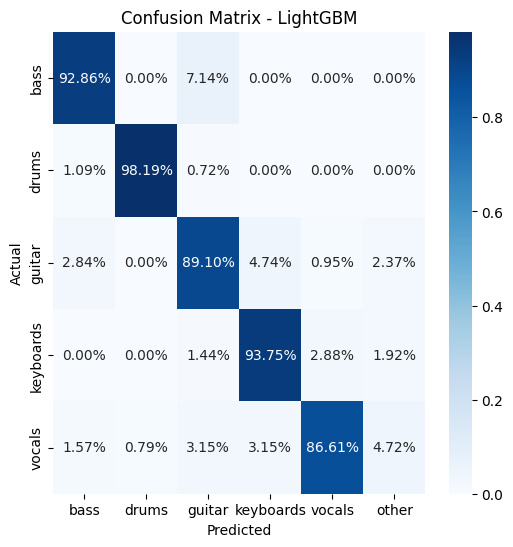

In [25]:
plot_confusion_matrix(y_test, X_test, lgbmc)

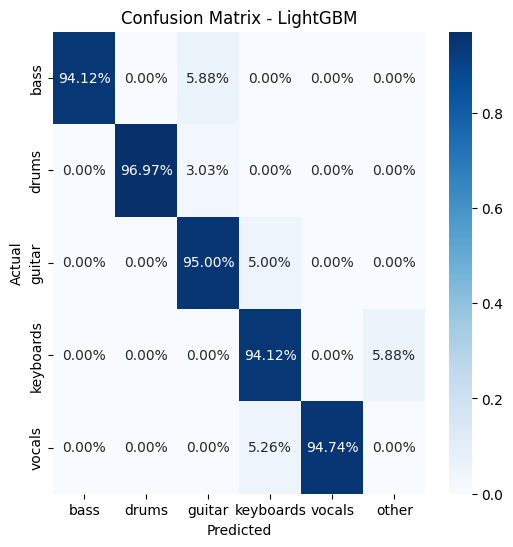

In [22]:
labels = lgbmc.classes_
cm = confusion_matrix(class_by_tracks['truth'].to_numpy(), class_by_tracks['prediction'].to_numpy(), labels=labels)[: len(labels) - 1]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(len(labels), len(labels)))
sns.heatmap(
    cm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels[:-1],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {lgbmc.name}')
plt.show()

In [24]:
print_classification_report(class_by_tracks['truth'].to_numpy(), class_by_tracks['prediction'].to_numpy(), labels=labels)

              precision    recall  f1-score   support

        bass       1.00      0.94      0.97        17
       drums       1.00      0.97      0.98        33
      guitar       0.90      0.95      0.93        20
   keyboards       0.89      0.94      0.91        17
      vocals       1.00      0.95      0.97        19
       other       0.00      0.00      0.00         0

    accuracy                           0.95       106
   macro avg       0.80      0.79      0.79       106
weighted avg       0.96      0.95      0.96       106



/Users/itallosilva/Workspace/indaband/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itallosilva/Workspace/indaband/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itallosilva/Workspace/indaband/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beh

In [26]:
class_by_tracks[class_by_tracks['prediction'] != class_by_tracks['truth']]

,track_id,truth,prediction
1,006b2f8c-aa5d-4cb6-a868-b73a2614c958,guitar,keyboards
19,092fba76-2b0f-42d1-832d-f0c7c9952271,keyboards,other
34,252b6ce2-02cc-4dbd-8255-b7e5d3323dcc,drums,guitar
67,6f817f62-ff0d-4a74-ac69-d38a49b2e1f7,bass,guitar
72,78b8c0cb-dc7c-4df9-89d2-3660a45f20ce,vocals,keyboards
